# Plot results

In [83]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools as itt
import json
import matplotlib.pyplot as plt
import graph_tool as gt
import graph_tool.stats as gts
import graph_tool.topology as gtt
from pathlib import Path
import numpy as np
import scipy.stats as sps
from matplotlib import rc

In [98]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['pdf.fonttype'] = 42

---
## Create plots for local distances

In [126]:
local_distances_1 = pd.read_csv('../results/disease_gene_vs_disease_est_comorbidity/local_distances.csv')
local_distances_1['scenario'] = ['Gene- vs. comorbidity-based diseasome' for _ in range(local_distances_1.shape[0])]
local_distances_2 = pd.read_csv('../results/disease_gene_vs_disease_drug/local_distances.csv')
local_distances_2['scenario'] = ['Gene- vs. drug-based diseasome' for _ in range(local_distances_2.shape[0])]
local_distances_3 = pd.read_csv('../results/drug_disease_vs_drug_target/local_distances.csv')
local_distances_3['scenario'] = ['Target- vs. indication-based drugome' for _ in range(local_distances_3.shape[0])]
local_distances = pd.concat([local_distances_1, local_distances_2, local_distances_3], ignore_index=True)

In [127]:
local_distances.rename(columns={'distance': 'Local distance', 'permuted': 'Permuted'}, inplace=True)

In [128]:
maxima = [[831.000000, 878.520506, 1368.300642],
          [393.000000, 413.422034, 613.718173],
          [997.000000, 1113.479972, 1525.866314]]

In [125]:
# See global_mwu_p_values.csv files in the respective results directories.
p_values = [[0.07480122263225282, 0.08661841997110292, 0.043780080417901136],
            [0.06241322048562586, 0.10820160906176457, 0.20704179489807917],
            [0.0001793945481447666, 0.001445782738263339, 0.0012541179894100542]]
p_equals = r'$P\simeq$'
p_value_strings = [[r'ns ($P\simeq7.45\times10^{-2}$)',r'ns ($P\simeq8.66\times10^{-2}$)',r'* ($P\simeq4.37\times10^{-2}$)'],
             [r'ns ($P\simeq6.24\times10^{-2}$)',r'ns ($P\simeq1.08\times10^{-1}$)',r'ns ($P\simeq2.07\times10^{-1}$)'],
             [r'*** ($P\simeq1.79\times10^{-4}$)',r'** ($P\simeq1.45\times10^{-3}$)',r'** ($P\simeq1.25\times10^{-3}$)']]
#p_value_strings = [[f'{p_value_to_level(p_value)} ({p_value})' for p_value in vals] for vals in p_values]

In [55]:
def adjust_titles(fig, width=60):
    subfig = 'A'
    for axis in fig.axes.flatten():
        title = axis.get_title().split(' = ')[1]
        axis.set_title('')
        title = r"$\bf{" + subfig + "}$  " + title
        if len(title) > width:
            words = title.split(' ')
            title=''
            length_line = 0
            for word in words:
                if title == '':
                    title = word
                    length_line = len(word)
                elif length_line + len(word) + 1 <= width:
                    title = f'{title} {word}'
                    length_line += 1 + len(word)
                else:
                    title = f"{title}\n{word}"
                    length_line = len(word)
        subfig = chr(ord(subfig) + 1)
        axis.set_title(title, loc='left')

In [40]:
def adjust_x_ticks(fig):
    for axis in fig.axes.flatten():
        axis.set_xlabel('')
        xticklabels = [text.get_text() for text in axis.get_xticklabels()]
        axis.set_xticklabels([' '.join(label.capitalize().split('_')) for label in xticklabels])

In [41]:
def p_value_to_level(p_value):
    if p_value > 0.05:
        return 'ns'
    elif p_value > 0.01:
        return '*'
    elif p_value > 0.001:
        return '**'
    elif p_value > 0.0001:
        return '***'
    else:
        return '****'
    
def add_p_values(fig, p_value_strings, maxima):
    for axis_index, axis in enumerate(fig.axes.flatten()):
        bottom, top = axis.get_ylim()
        axis.set_ylim(top=top + (top - bottom) * .1)
        for x_pos, text in enumerate(p_value_strings[axis_index]):
            axis.text(x_pos, maxima[axis_index][x_pos] + (top - bottom) * .05, text, ha='center', va='bottom')

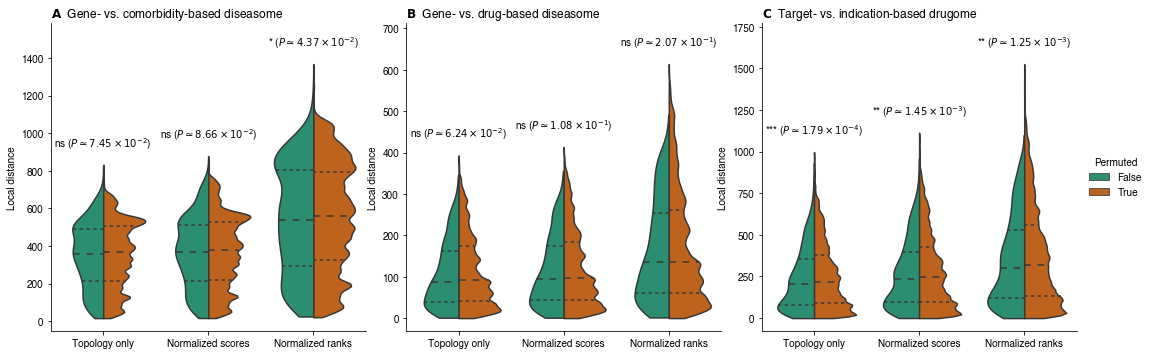

In [129]:
fig = sns.catplot(data=local_distances, sharey=False, palette='Dark2', x='distance_type', col='scenario', hue='Permuted', split=True, kind='violin', y='Local distance', cut=0, inner='quartiles')
adjust_titles(fig)
adjust_x_ticks(fig)
for axis in fig.axes.flatten():
    axis.set_ylabel('Local distance')
add_p_values(fig, p_value_strings, maxima)

In [130]:
fig.savefig('local_distances.pdf')
fig.savefig('local_distances.png', dpi=600)

---
## Create plots for global distances

In [107]:
global_distances_1 = pd.read_csv('../results/disease_gene_vs_disease_est_comorbidity/global_distances.csv')
global_distances_1['scenario'] = ['Gene- vs. comorbidity-based diseasome' for _ in range(global_distances_1.shape[0])]
global_distances_2 = pd.read_csv('../results/disease_gene_vs_disease_drug/global_distances.csv')
global_distances_2['scenario'] = ['Gene- vs. drug-based diseasome' for _ in range(global_distances_2.shape[0])]
global_distances_3 = pd.read_csv('../results/drug_disease_vs_drug_target/global_distances.csv')
global_distances_3['scenario'] = ['Target- vs. indication-based drugome' for _ in range(global_distances_3.shape[0])]
global_distances = pd.concat([global_distances_1, global_distances_2, global_distances_3], ignore_index=True)

In [108]:
global_distances.rename(columns={'distance': 'Global distance', 'permuted': 'Permuted'}, inplace=True)

In [109]:
delta_name = 'Difference between original and permuted global distance'
global_distances[delta_name] = [0.0 for _ in range(global_distances.shape[0])]
distance_types = list(set(global_distances['distance_type']))
scenarios = list(set(global_distances['scenario']))
for distance_type in distance_types:
    dt_filter = global_distances['distance_type'] == distance_type
    for scenario in scenarios:
        sc_filter = global_distances['scenario'] == scenario
        true_distance = global_distances['Global distance'][~global_distances['Permuted'] & dt_filter & sc_filter].to_numpy()[0]
        differences = global_distances['Global distance'][dt_filter & sc_filter].to_numpy() - true_distance
        global_distances.loc[dt_filter & sc_filter, delta_name] = differences

In [133]:
maxima = [[4198.000000, 4536.949275, 9192.181612],
          [2612.000000, 2708.770529, 3552.364895],
          [15598.000000, 18198.053238, 24715.886169]]

In [137]:
# See global_empirical_p_values.csv files in the respective results directories.
p_value = 0.000999000999000999
p_value_strings = [[r'*** ($P\simeq9.99\times10^{-4}$)' for _ in range(3)] for _ in range(3)]

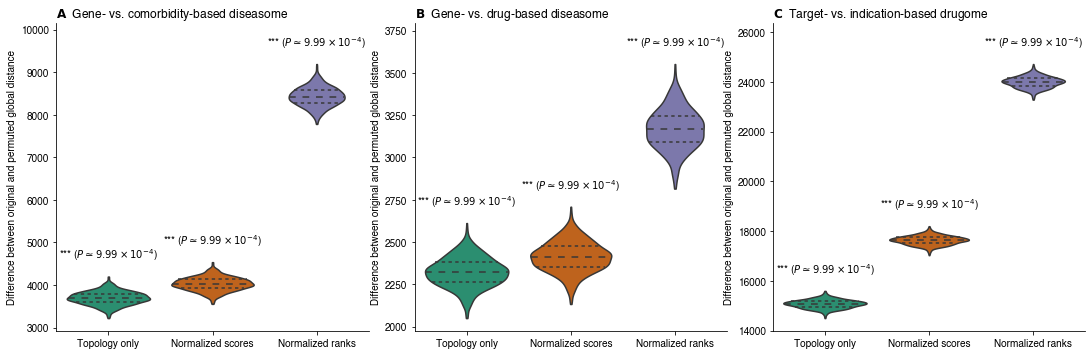

In [138]:
fig = sns.catplot(data=global_distances[global_distances['Permuted']], sharey=False, inner='quartiles', kind='violin', cut=0, palette='Dark2', x='distance_type', col='scenario', y=delta_name)
adjust_titles(fig)
adjust_x_ticks(fig)
for axis in fig.axes.flatten():
    axis.set_ylabel('Difference between original and permuted global distance')
add_p_values(fig, p_value_strings, maxima)

In [139]:
fig.savefig('difference_global_distances.pdf')
fig.savefig('difference_global_distances.png', dpi=600)

---
## Create plots for local empirical p-values

In [114]:
p_values_1 = pd.read_csv('../results/disease_gene_vs_disease_est_comorbidity/local_empirical_p_values.csv')
p_values_1['scenario'] = ['Gene- vs. comorbidity-based diseasome' for _ in range(p_values_1.shape[0])]
p_values_2 = pd.read_csv('../results/disease_gene_vs_disease_drug/local_empirical_p_values.csv')
p_values_2['scenario'] = ['Gene- vs. drug-based diseasome' for _ in range(p_values_2.shape[0])]
p_values_3 = pd.read_csv('../results/drug_disease_vs_drug_target/local_empirical_p_values.csv')
p_values_3['scenario'] = ['Target- vs. indication-based drugome' for _ in range(p_values_3.shape[0])]
p_values = pd.concat([p_values_1, p_values_2, p_values_3], ignore_index=True)
p_values.rename(columns={'p_value': 'Local empirical p-value', 'distance_type': 'Distance type'}, inplace=True)
p_values['Distance type'] = p_values['Distance type'].apply(lambda label: ' '.join(label.capitalize().split('_')))

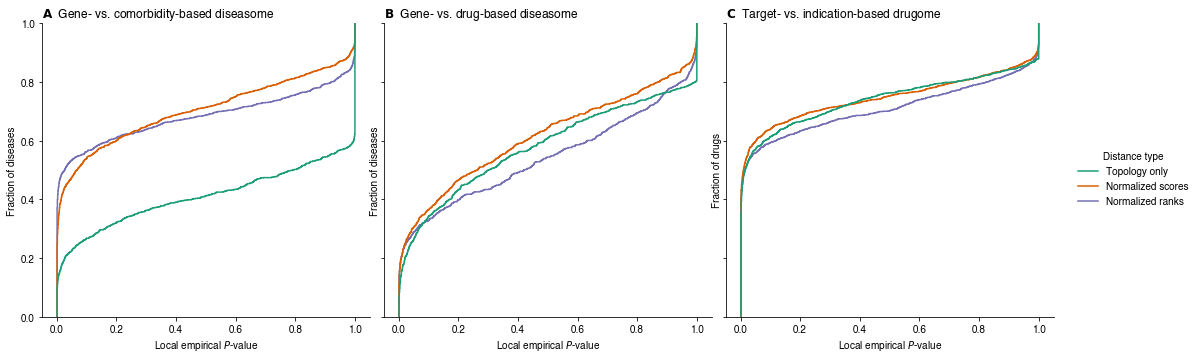

In [115]:
fig = sns.displot(data=p_values, kind='ecdf', palette='Dark2',hue_order=['Topology only', 'Normalized scores', 'Normalized ranks'], hue='Distance type', col='scenario', x='Local empirical p-value')
for axis in fig.axes.flatten():
    axis.set_ylabel('Fraction of nodes')
fig.set_xlabels('Local empirical ' + r'$P$' + '-value')
for counter, axis in enumerate(fig.axes.flatten()):
    if counter < 2:
        axis.set_ylabel('Fraction of diseases')
    else:
        axis.set_ylabel('Fraction of drugs')
adjust_titles(fig)

In [116]:
fig.savefig('local_empirical_p_values.pdf')
fig.savefig('local_empirical_p_values.png', dpi=600)

---
## Create plots for distances vs. reference edges

In [117]:
distances_1 = pd.read_csv('../results/disease_distances_vs_comorbidities/shortest_path_distances.csv')
distances_1['scenario'] = ['Disease distances vs. comorbidities' for _ in range(distances_1.shape[0])]
distances_2 = pd.read_csv('../results/disease_distances_vs_shared_drugs/shortest_path_distances.csv')
distances_2['scenario'] = ['Disease distances vs. shared drugs' for _ in range(distances_2.shape[0])]
distances_3 = pd.read_csv('../results/drug_distances_vs_shared_indications/shortest_path_distances.csv')
distances_3['scenario'] = ['Drug distances vs. shared indications' for _ in range(distances_3.shape[0])]
distances = pd.concat([distances_1, distances_2, distances_3], ignore_index=True)

In [118]:
fractions = {'scenario': [], 'reference_edge': [], 'distance': [], 'fraction': []}
scenarios = list(set(distances['scenario']))
ref_filter = distances['reference_edge']
for scenario in scenarios:
    sc_filter = (distances['scenario'] == scenario)
    num_ref = distances[sc_filter & ref_filter].shape[0]
    num_non_ref = distances[sc_filter & ~ref_filter].shape[0]
    distance_values = set(distances[sc_filter]['distance'])
    for distance_value in distance_values:
        dist_filter = (distances['distance'] == distance_value)
        num_ref_with_dist = distances[sc_filter & ref_filter & dist_filter].shape[0]
        num_non_ref_with_dist = distances[sc_filter & ~ref_filter & dist_filter].shape[0]
        fractions['scenario'].append(scenario)
        fractions['scenario'].append(scenario)
        fractions['reference_edge'].append(True)
        fractions['reference_edge'].append(False)
        fractions['distance'].append(distance_value)
        fractions['distance'].append(distance_value)
        fractions['fraction'].append(num_ref_with_dist / num_ref)
        fractions['fraction'].append(num_non_ref_with_dist / num_non_ref)
fractions = pd.DataFrame(data=fractions)

In [119]:
frac_name = 'Fraction of disease pairs'
dist_name = 'Distance between diseases in disease-gene network'
ref_name = 'Edge in reference network'
fractions.rename(columns={'fraction': frac_name, 'distance': dist_name, 'reference_edge': ref_name}, inplace=True)

In [120]:
def add_axis_texts(fig, texts):
    for axis_index, axis in enumerate(fig.axes.flatten()):
        bottom, top = axis.get_ylim()
        left, right = axis.get_xlim()
        axis.text(right - (right - left) * .05, top - (top - bottom) * .05, texts[axis_index], ha='right', va='top')

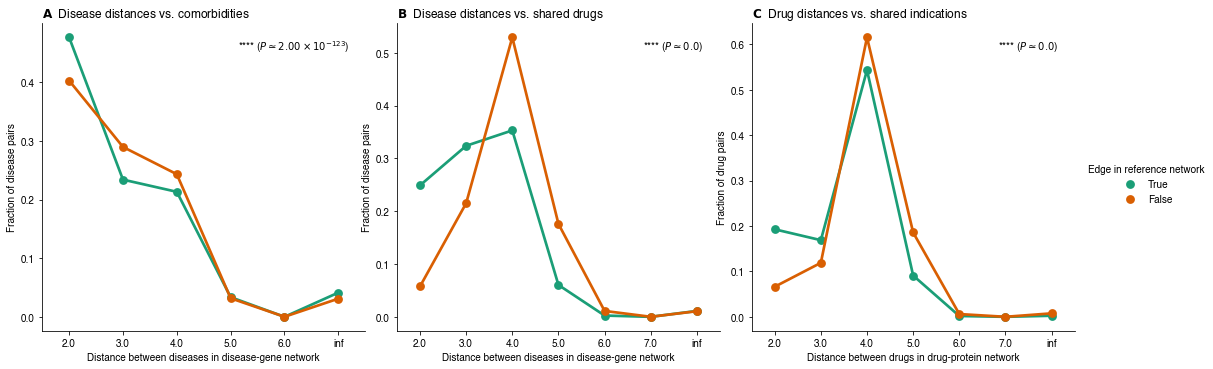

In [140]:
fig = sns.catplot(data=fractions, x=dist_name, col='scenario', hue_order=[True, False], palette='Dark2', 
                  sharex=False, sharey=False, hue=ref_name, y=frac_name, kind='point', 
                 col_order=['Disease distances vs. comorbidities', 'Disease distances vs. shared drugs',
                           'Drug distances vs. shared indications'])
adjust_titles(fig)
# See shortest_path_distance_analysis.json files in the respective results directories.
# texts = [f'{p_value_to_level(p_value)} ({p_equals}{p_value:.2E})' for p_value in [1.999516746437443e-123, 0.0, 0.0]]
texts = [r'**** ($P\simeq2.00\times10^{-123}$)',r'**** ($P\simeq0.0$)',r'**** ($P\simeq0.0$)']
for counter, axis in enumerate(fig.axes.flatten()):
    if counter < 2:
        axis.set_ylabel('Fraction of disease pairs')
    else:
        axis.set_xlabel('Distance between drugs in drug-protein network')
        axis.set_ylabel('Fraction of drug pairs')
add_axis_texts(fig, texts)

In [141]:
fig.savefig('distances_vs_reference_edges.pdf')
fig.savefig('distances_vs_reference_edges.png', dpi=600)

---
## Create plots for distances vs. scores

In [123]:
distances.fillna(value=0.0, inplace=True)
inf_filter = (distances['distance'] < np.inf)
score_name = 'Edge score in reference graph'
distances.rename(columns={'distance': dist_name, 'reference_score': score_name}, inplace=True)

In [ ]:
scatter_kws = {'color': 'black', 's': 4}
fig = sns.lmplot(data=distances[inf_filter], markers='x', palette='Dark2', scatter_kws=scatter_kws,
                 y=dist_name, x=score_name, sharex=False, sharey=False, col='scenario',
                 col_order=['Disease distances vs. comorbidities', 'Disease distances vs. shared drugs',
                           'Drug distances vs. shared indications'])
adjust_titles(fig)
#analyses = [(8.931901267234434e-162, -2.808275749982158), (0.0, -2.6358200996754326), (0.0, -1.310492458785064)]
#texts = [f'{p_value_to_level(p)} ({p_equals}{p:.2E})\nslope: {slope:.2f}' for p, slope in analyses]
texts = [r'**** ($P\simeq8.93\times10^{-162}$)' + '\n' + r'slope$\simeq-2.81$',
         r'**** ($P\simeq0.0$)' + '\n' + r'slope$\simeq-2.64$',
         r'**** ($P\simeq0.0$)' + '\n' + r'slope$\simeq-1.31$']
for counter, axis in enumerate(fig.axes.flatten()):
    if counter < 2:
        axis.set_ylabel('Distance between diseases in disease-gene network')
    else:
        axis.set_ylabel('Distance between drugs in drug-protein network')
    if counter == 0:
        axis.set_xlabel(r'$\phi$' + '-correlation')
    else:
        axis.set_xlabel('Jaccard index')
add_axis_texts(fig, texts)

In [77]:
fig.savefig('distances_vs_reference_scores.pdf')
fig.savefig('distances_vs_reference_scores.png', dpi=600)